# ***Assignment 1.3 - CAVI***
Consider the model defined by Equation (10.21)-(10-23) in Bishop, for which DGM is presented below:

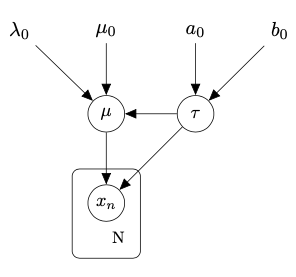

### ***Question 1.3.12:***

Implement a function that generates data points for the given model.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import norm, gamma

In [2]:
def generate_data(mu, tau, N):
    D = np.random.normal(loc = mu, scale = (1/tau), size = N)
    return D


Set μ = 1, τ = 0.5 and generate datasets with size N=10,100,1000. Plot the histogram for each of 3
datasets you generated.



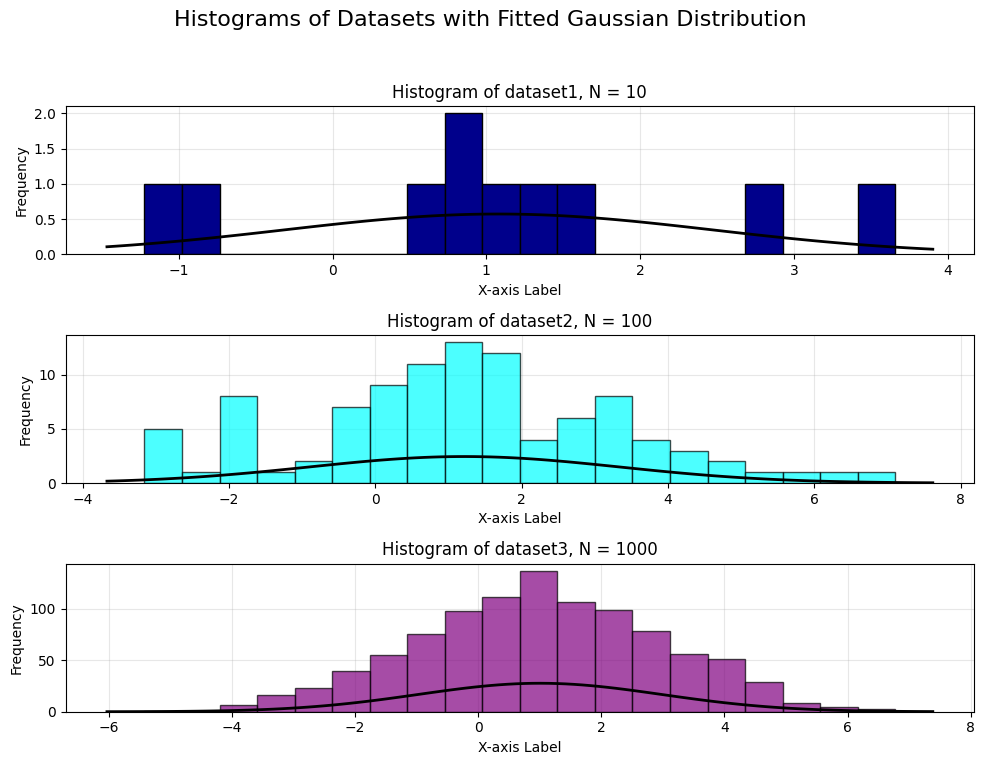

In [3]:
mu = 1
tau = 0.5

dataset_1 = generate_data(mu, tau, 10)
dataset_2 = generate_data(mu, tau, 100)
dataset_3 = generate_data(mu, tau, 1000)

datasets = [dataset_1,dataset_2,dataset_3] 

# Visualize the datasets via histograms
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(10, 8))

# Plot histograms and add line along the distribution
for i, dataset in enumerate([dataset_1, dataset_2, dataset_3]):
    bins = 20
    color = ['darkblue', 'cyan', 'purple'][i]
    alpha = [1.0, 0.7, 0.7][i]

    # Histogram
    n, bins, _ = axes[i].hist(dataset, bins=bins, color=color, alpha=alpha, edgecolor='black', zorder=2)
    axes[i].set_title(f'Histogram of dataset{i+1}, N = {len(dataset)}')
    axes[i].set_xlabel('X-axis Label')
    axes[i].set_ylabel('Frequency')

    # Fit a normal distribution to the data
    mu_fit, std_fit = norm.fit(dataset)

    # Plot the fitted Gaussian distribution
    xmin, xmax = axes[i].get_xlim()
    x = np.linspace(xmin, xmax, 100)
    p = norm.pdf(x, mu_fit, std_fit) * np.max(n)
    axes[i].plot(x, p, 'k', linewidth=2, zorder=3)

    # Set grid below histograms
    axes[i].grid(True, alpha=0.3, zorder=1)
    axes[i].set_axisbelow(True)

# Overall title
plt.suptitle('Histograms of Datasets with Fitted Gaussian Distribution', fontsize=16)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

### ***Question 1.3.13:***

Find ML estimates of the variables μ and τ

In [4]:
def ML_est(data):
    mu_ml = np.mean(data)
    tau_ml = (1/(np.var(data)))
    return mu_ml, tau_ml

In [5]:
# ML estimates for the datasets
for dataset in datasets:
    mu, tau = ML_est(dataset)
    print(f"mu = {mu}, tau = {tau}, N = {len(dataset)}")

mu = 1.0784506298954164, tau = 0.5150368611878423, N = 10
mu = 1.2163336389907733, tau = 0.22216368949805884, N = 100
mu = 1.0027410270527204, tau = 0.25611262273969393, N = 1000


In [6]:
# prior parameters
mu_0 = 0
lambda_0 = 1
a_0 = 1
b_0 = 1

Continue with a helper function that computes ELBO:


In [7]:
from scipy.special import digamma, gamma, gammaln
def compute_elbo(D, a_0, b_0, mu_0, lambda_0, a_N , b_N, mu_N, lambda_N):
    # expected values
    E_tao = a_N / b_N
    E_log_tao = np.log(b_N) - digamma(a_N)
    E_mu = mu_N
    mse = np.sum((D-np.mean(D))**2)
    E_mu_sq = mu_N**2
    
    # pdfs
    E_log_p_x_mu_tao = (1/lambda_0) - (1/2 * E_tao * np.sum((D**2)-D*2*E_mu+E_mu_sq)) + (len(D)*E_log_tao/2) - (len(D)*np.log(2*np.pi))
    E_log_p_mu_tao = 0.5*(np.log(lambda_0)+digamma(a_N)-np.log(b_N)-np.log(2*np.pi) -lambda_0*((np.mean(D)**2)+(len(D)/(len(D)-1))*(mse)+2*mu_0*np.mean(D)+mu_0**2)*((len(D)-1)/mse))
    E_log_p_tao = a_0*np.log(b_0)-gammaln(a_0)+(a_0-1)*(digamma(a_N)-np.log(b_N))-((b_0*a_N)/(b_N))

    # entropies
    E_log_q_mu = 1/2 * np.log((2*np.pi/(E_tao*lambda_N+len(D))))
    E_log_q_tao = a_N-np.log(b_N)+gammaln(a_N)+(1-a_N)*digamma(a_N)
    
    elbo = E_log_p_x_mu_tao + E_log_p_mu_tao + E_log_p_tao + E_log_q_mu + E_log_q_tao
    return elbo

Now, implement the CAVI algorithm:

In [8]:
def CAVI(D, a_0, b_0, mu_0, lambda_0):
    # make an initial guess for the expected value of tau
    initial_guess_exp_tau = 2
    iterations = 10
    x_bar = np.mean(D)
    N = len(D)
    
    # initialize res arrays
    elbos = np.zeros(iterations)
    mu_N = np.zeros(iterations)
    lambda_N = np.zeros(iterations)
    a_N = np.zeros(iterations)
    b_N = np.zeros(iterations)

    # CAVI iterations
    for i in range(iterations):
        
        # update parameters
        a_N[i] = a_0 + ((N + 1)/2)
        mu_N[i] = ((lambda_0*mu_0) + (N*x_bar))/(lambda_0 + N)
        
        # deal with lambdas and bs circular dependency
        if i == 0:
            lambda_N[i] = (lambda_0+N)*initial_guess_exp_tau
        else:
            lambda_N[i] = (lambda_0+N)*(a_N[i]/b_N[i-1])
       
        b_N[i] = b_0 + (1/2) * ((lambda_0 + N) * (1/lambda_N[i] + mu_N[i]**2) - 2 * ((lambda_0 * mu_0 + np.sum(D)*(mu_N[i]))) + np.sum(D**2) + (lambda_0 * mu_0**2))
        
        # save the elbo values
        elbos[i] = compute_elbo(D, a_0, b_0, mu_0, lambda_0, a_N[i], b_N[i], mu_N[i], lambda_N[i])

    return a_N, b_N, mu_N, lambda_N, elbos

In [9]:
def plot_parameters(a_N, b_N, mu_N, lambda_N, elbos):
    for param in ['figure.facecolor', 'axes.facecolor', 'savefig.facecolor']:
        plt.rcParams[param] = '#222222' 
    for param in ['text.color', 'axes.labelcolor', 'xtick.color', 'ytick.color']:
        plt.rcParams[param] = '0.9'  

    fig, axes = plt.subplots(5, 1, figsize=(10, 15))

    # Plot a_N
    axes[0].plot(a_N, color='orange', linewidth=2)
    axes[0].set_ylabel('a_N', fontsize=12)
    axes[0].set_xlabel('Iteration', fontsize=12)
    axes[0].grid(True, linestyle='--', alpha=0.7)

    # Plot b_N
    axes[1].plot(b_N, color='green', linewidth=2)
    axes[1].set_ylabel('b_N', fontsize=12)
    axes[1].set_xlabel('Iteration', fontsize=12)
    axes[1].grid(True, linestyle='--', alpha=0.7)

    # Plot mu_N
    axes[2].plot(mu_N, color='blue', linewidth=2)
    axes[2].set_ylabel('mu_N', fontsize=12)
    axes[2].set_xlabel('Iteration', fontsize=12)
    axes[2].grid(True, linestyle='--', alpha=0.7)

    # Plot lambda_N
    axes[3].plot(lambda_N, color='red', linewidth=2)
    axes[3].set_ylabel('lambda_N', fontsize=12)
    axes[3].set_xlabel('Iteration', fontsize=12)
    axes[3].grid(True, linestyle='--', alpha=0.7)

    # Plot ELBO
    axes[4].plot(elbos, color='cyan', linewidth=2)
    axes[4].set_ylabel('ELBO', fontsize=12)
    axes[4].set_xlabel('Iteration', fontsize=12)
    axes[4].grid(True, linestyle='--', alpha=0.7)
    
    # Adjust spacing between subplots
    plt.subplots_adjust(hspace=0.5)

    plt.suptitle('Parameter Values Over Iterations', fontsize=14)
    plt.show()

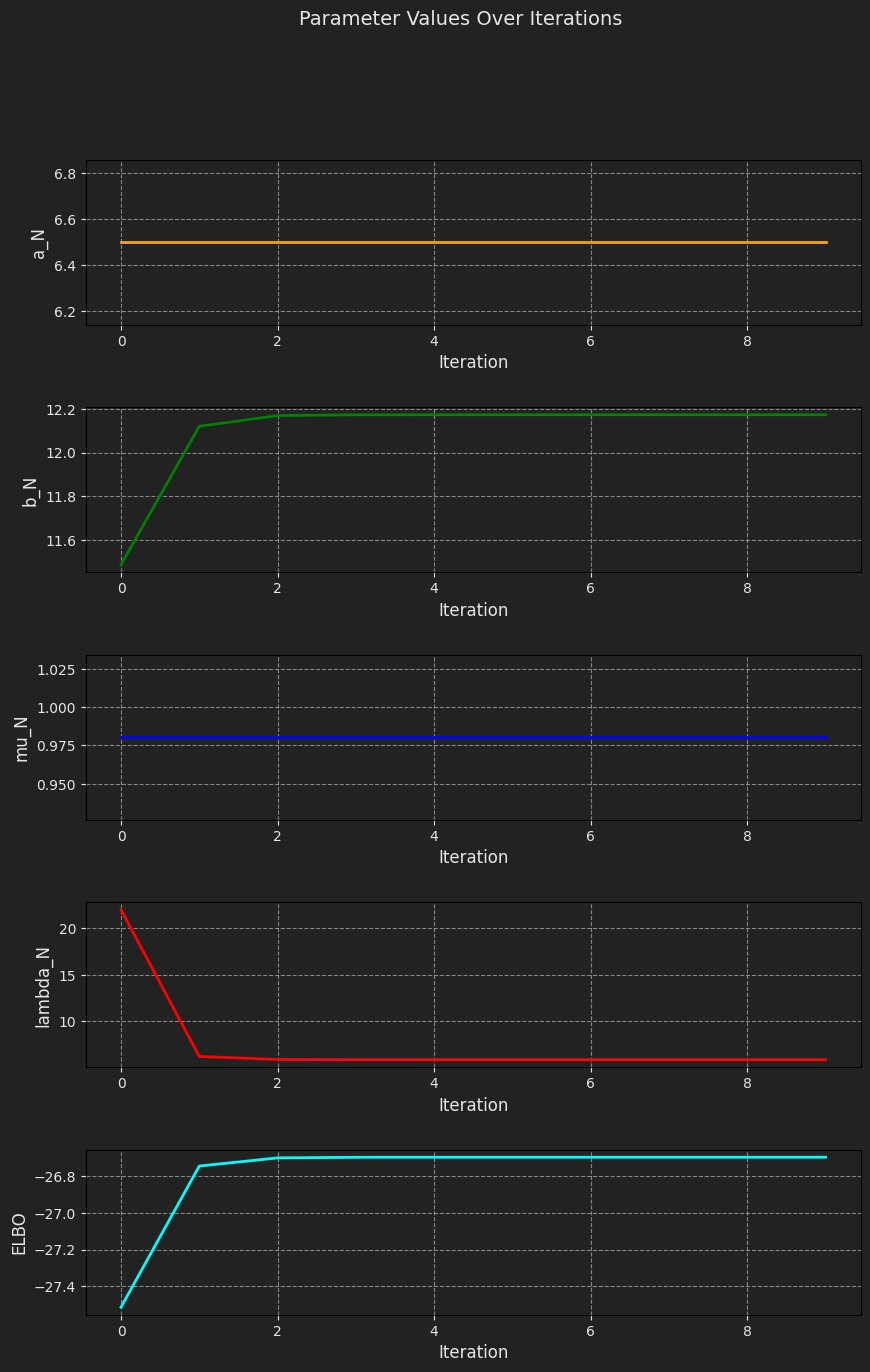

In [10]:
a_N, b_N, mu_N, lambda_N, elbos = CAVI(dataset_1, a_0, b_0, mu_0, lambda_0)
plot_parameters(a_N, b_N, mu_N, lambda_N, elbos)

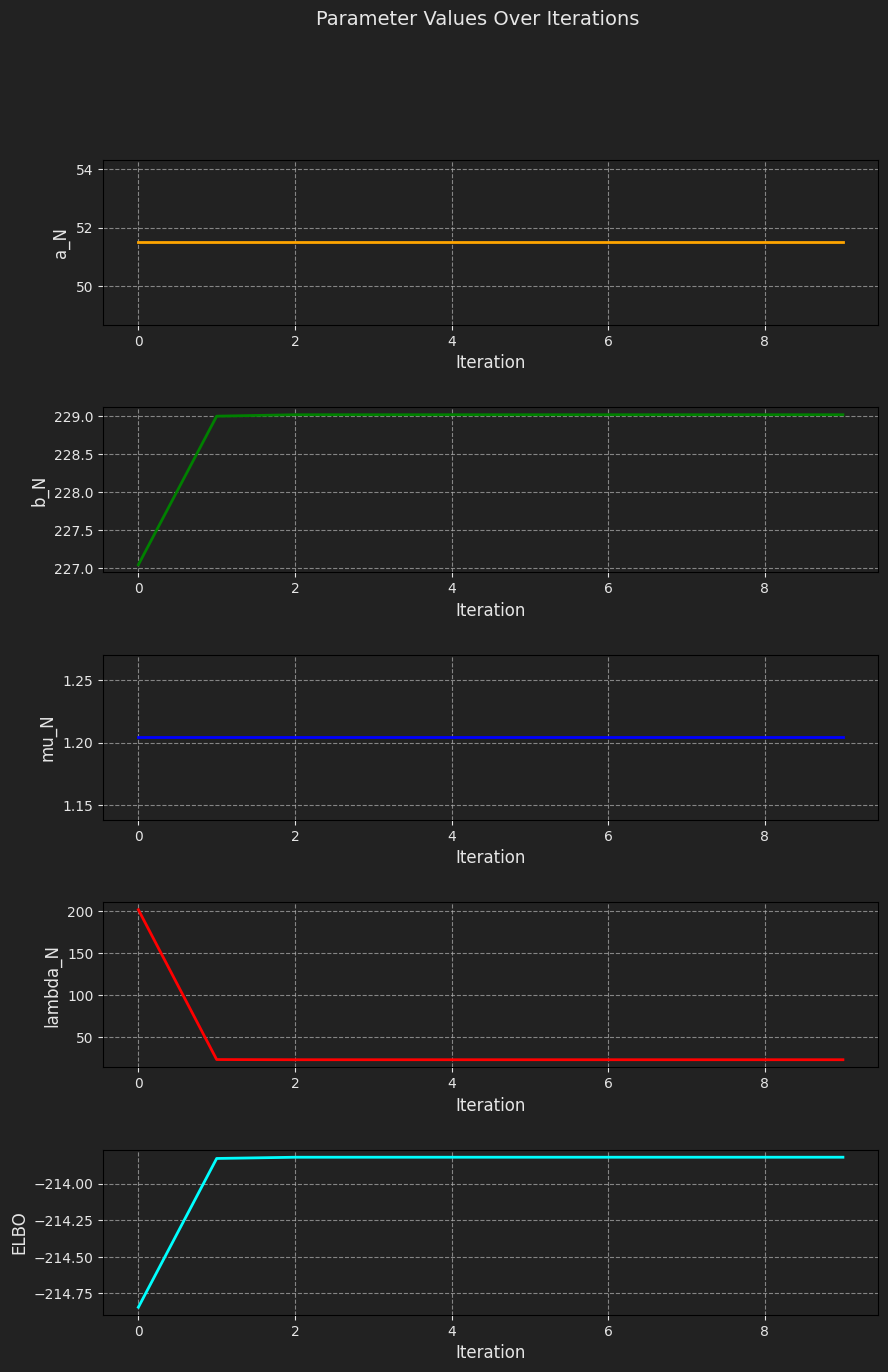

In [11]:
a_N, b_N, mu_N, lambda_N, elbos = CAVI(dataset_2, a_0, b_0, mu_0, lambda_0)
plot_parameters(a_N, b_N, mu_N, lambda_N, elbos)

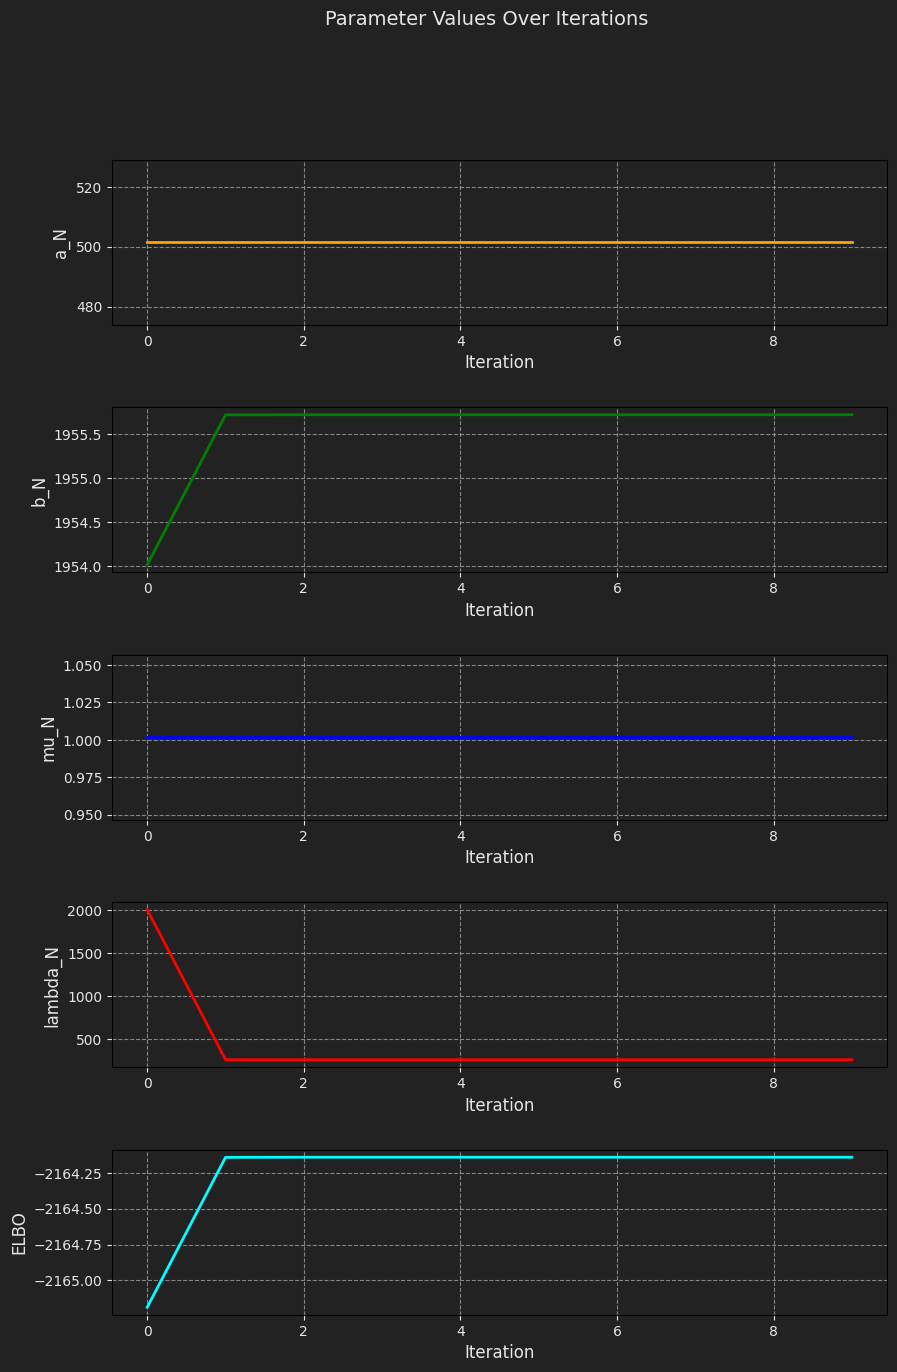

In [12]:
a_N, b_N, mu_N, lambda_N, elbos = CAVI(dataset_3, a_0, b_0, mu_0, lambda_0)
plot_parameters(a_N, b_N, mu_N, lambda_N, elbos)

### ***Question 1.3.15:***

What is the exact posterior? First derive it in closed form, and then implement a function that computes it for the given parameters:


In [13]:
import scipy.stats as stats
def compute_exact_posterior(mu, tau, D, a_0, b_0, mu_0, lambda_0):
    # Calculate updated parameters
    exact_a = (len(D) / 2) + a_0
    exact_b = (
        b_0
        + 0.5 * (np.sum(D**2)
        + (lambda_0 * mu_0**2)
        - (((np.sum(D) + (mu_0 * lambda_0))**2) / (len(D) + lambda_0)))
    )
    exact_lambda = lambda_0 + len(D)
    exact_mu = (np.sum(D) + mu_0 * lambda_0) / (len(D) + lambda_0)
    
    exact_posterior = np.exp((exact_a-1)*np.log(tau) - tau*(exact_b)-(tau/2)*(exact_lambda*(mu-exact_mu)**2))
    return exact_posterior

### ***Question 1.3.16:***
Run the VI algorithm on the datasets. Compare the inferred variational
distribution with the exact posterior and the ML estimate. Visualize the results and discuss your
findings.

In [14]:
# get maximum likelihood estimates
ml_mu1, ml_tau1 = ML_est(dataset_1)
ml_mu2, ml_tau2 = ML_est(dataset_2)
ml_mu3, ml_tau3 = ML_est(dataset_3)

ML = [(ML_est(x)) for x in datasets]

# creating a grid for plotting
mu_values = np.linspace(0,3, 100)
tau_values = np.linspace(0.1,1.5, 100) 
mu_grid, tau_grid = np.meshgrid(mu_values, tau_values)
pos = np.dstack((mu_grid, tau_grid))

# exact posterior for datasets 1-3
ep1 = compute_exact_posterior(pos[:,:,0], pos[:,:,1], dataset_1, a_0, b_0, mu_0, lambda_0)
ep2 = compute_exact_posterior(pos[:,:,0], pos[:,:,1], dataset_2, a_0, b_0, mu_0, lambda_0)
ep3 = compute_exact_posterior(pos[:,:,0], pos[:,:,1], dataset_3, a_0, b_0, mu_0, lambda_0)

exact_posteriors = [ep1,ep2,ep3]

# inferred variational parameters for dataset 1
cavi = CAVI(dataset_1, a_0, b_0, mu_0, lambda_0)
# prior parameters
aN = a_0
bN = b_0
muN = mu_0
lambdaN = lambda_0

# converged
aN = cavi[0][-1]
bN = cavi[1][-1]
muN = cavi[2][-1]
lambdaN = cavi[3][-1]

# inferred variational parameters for dataset 2
cavi2 = CAVI(dataset_2, a_0, b_0, mu_0, lambda_0)
aN2 = cavi2[0][-1]
bN2 = cavi2[1][-1]
muN2 = cavi2[2][-1]
lambdaN2 = cavi2[3][-1]

# inferred variational parameters for dataset 3
cavi3 = CAVI(dataset_3, a_0, b_0, mu_0, lambda_0)
aN3 = cavi3[0][-1]
bN3 = cavi3[1][-1]
muN3 = cavi3[2][-1]
lambdaN3 = cavi3[3][-1]

# cavi posterior for prior parameters for datasets 1-3
q_mu_tau1_prior = stats.norm.pdf(pos[:,:,0], loc=muN, scale=1.0 / (cavi[3][0]*pos[:,:,1])) * stats.gamma.pdf(pos[:,:,1], a=aN, scale=1.0 / cavi[1][0])
q_mu_tau2_prior = stats.norm.pdf(pos[:,:,0], loc=muN2, scale=1.0 / (cavi2[3][0]*pos[:,:,1])) * stats.gamma.pdf(pos[:,:,1], a=aN2, scale=1.0 / cavi2[1][0])
q_mu_tau3_prior = stats.norm.pdf(pos[:,:,0], loc=muN3, scale=1.0 / (cavi3[3][0]*pos[:,:,1])) * stats.gamma.pdf(pos[:,:,1], a=aN3, scale=1.0 / cavi3[1][0])

# cavi posterior for converged parameters for datasets 1-3
q_mu_tau1 = stats.norm.pdf(pos[:,:,0], loc=muN, scale=1.0 / (lambdaN*pos[:,:,1])) * stats.gamma.pdf(pos[:,:,1], a=aN, scale=1.0 / bN)
q_mu_tau2 = stats.norm.pdf(pos[:,:,0], loc=muN2, scale=1.0 / (lambdaN2*pos[:,:,1])) * stats.gamma.pdf(pos[:,:,1], a=aN2, scale=1.0 / bN2)
q_mu_tau3 = stats.norm.pdf(pos[:,:,0], loc=muN3, scale=1.0 / (lambdaN3*pos[:,:,1])) * stats.gamma.pdf(pos[:,:,1], a=aN3, scale=1.0 / bN3)



/var/folders/_j/hc6yz5ys04z66vnnmxnn2x780000gn/T/ipykernel_81996/1400346207.py:17: UserWarning: No contour levels were found within the data range.
  ax3.contour(mu_grid, tau_grid, ep3, levels=5, cmap='magma', alpha=0.7, linewidths=4.)
/var/folders/_j/hc6yz5ys04z66vnnmxnn2x780000gn/T/ipykernel_81996/1400346207.py:29: UserWarning: No contour levels were found within the data range.
  ax6.contour(mu_grid, tau_grid, ep3, levels=5, cmap='magma', alpha=0.7, linewidths=4.)


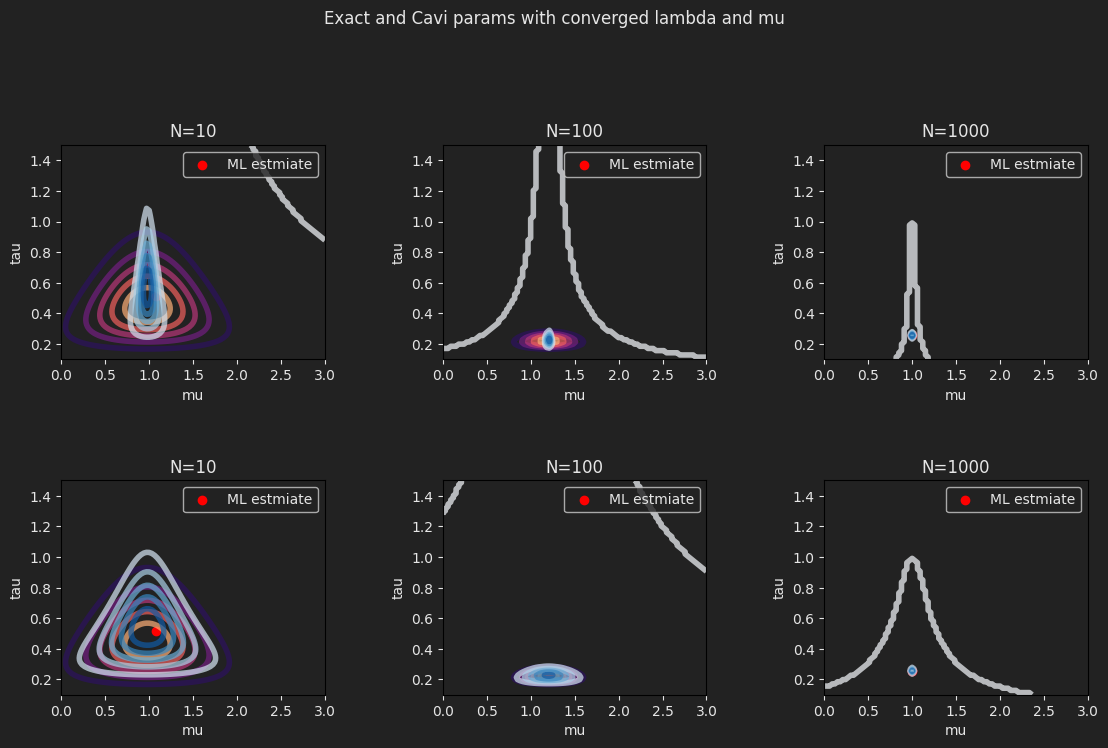

In [15]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(12,8))
ax1 = axes[0,0]
ax2 = axes[0,1]
ax3 = axes[0,2]
ax4 = axes[1,0]
ax5 = axes[1,1]
ax6 = axes[1,2]

ax1.contour(mu_grid, tau_grid, ep1, levels=6, cmap='magma', alpha=0.7, linewidths=4.)
ax1.contour(mu_grid, tau_grid, q_mu_tau1_prior, levels=5, cmap='Blues', alpha=0.7, linewidths=4.)
ax1.scatter(ml_mu1,ml_tau1,color="red", label="ML estmiate")

ax2.contour(mu_grid, tau_grid, ep2, levels=5, cmap='magma', alpha=0.7, linewidths=4.)
ax2.contour(mu_grid, tau_grid, q_mu_tau2_prior, levels=5, cmap='Blues', alpha=0.7, linewidths=4.)
ax2.scatter(ml_mu2,ml_tau2, color="red", label="ML estmiate")

ax3.contour(mu_grid, tau_grid, ep3, levels=5, cmap='magma', alpha=0.7, linewidths=4.)
ax3.contour(mu_grid, tau_grid, q_mu_tau3_prior, levels=5, cmap='Blues', alpha=0.7, linewidths=4.)
ax3.scatter(ml_mu3,ml_tau3, color="red", label="ML estmiate")

ax4.contour(mu_grid, tau_grid, ep1, levels=6, cmap='magma', alpha=0.7, linewidths=4.)
ax4.contour(mu_grid, tau_grid, q_mu_tau1, levels=5, cmap='Blues', alpha=0.7, linewidths=4.)
ax4.scatter(ml_mu1,ml_tau1,color="red", label="ML estmiate")

ax5.contour(mu_grid, tau_grid, ep2, levels=5, cmap='magma', alpha=0.7, linewidths=4.)
ax5.contour(mu_grid, tau_grid, q_mu_tau2, levels=5, cmap='Blues', alpha=0.7, linewidths=4.)
ax5.scatter(ml_mu2,ml_tau2, color="red", label="ML estmiate")

ax6.contour(mu_grid, tau_grid, ep3, levels=5, cmap='magma', alpha=0.7, linewidths=4.)
ax6.contour(mu_grid, tau_grid, q_mu_tau3, levels=5, cmap='Blues', alpha=0.7, linewidths=4.)
ax6.scatter(ml_mu3,ml_tau3, color="red", label="ML estmiate")

ax1.legend()
ax2.legend()
ax3.legend()
ax4.legend()
ax5.legend()
ax6.legend()
fig.suptitle("Exact and Cavi params with converged lambda and mu")
ax1.set_title("N=10")
ax2.set_title("N=100")
ax3.set_title("N=1000")
ax4.set_title("N=10")
ax5.set_title("N=100")
ax6.set_title("N=1000")
    

ax1.set_xlabel('mu')
ax1.set_ylabel('tau')
ax2.set_xlabel('mu')
ax2.set_ylabel('tau')
ax3.set_xlabel('mu')
ax3.set_ylabel('tau')
ax4.set_xlabel('mu')
ax4.set_ylabel('tau')
ax5.set_xlabel('mu')
ax5.set_ylabel('tau')
ax6.set_xlabel('mu')
ax6.set_ylabel('tau')
fig.tight_layout(pad=4.0)